Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Training models

In this tutorial, we demonstrate TorchGeo trainers to train and test a model. Specifically, we will use the [Tropical Cyclone dataset](https://torchgeo.readthedocs.io/en/latest/api/datasets.html#tropical-cyclone-wind-estimation-competition) and train models to predict cyclone windspeed given imagery of the cyclone. 

It's recommended to run this notebook on Google Colab if you don't have your own GPU. Click the "Open in Colab" button above to get started.

## Setup

First, we install TorchGeo.

TODO: this should be updated to use `pip install torchgeo` once we release on PyPI.

In [1]:
import os
import sys

sys.path.append(os.path.join("..", ".."))

## Imports

Next, we import TorchGeo and any other libraries we need.

In [2]:
%matplotlib inline
import csv
import tempfile

import numpy as np
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchgeo.trainers import CycloneSimpleRegressionTask, CycloneDataModule

## Setup lightning modules

Our trainers use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) to organize both the training code, and the dataloader setup code. This makes it easy to create and share reproducible experiments and results.

First we'll create a `CycloneDataModule` object which is simply a wrapper around the [`TropicalCycloneWindEstimation`](https://torchgeo.readthedocs.io/en/latest/api/datasets.html#tropical-cyclone-wind-estimation-competition) dataset. This object 1.) ensures that the data is downloaded*, 2.) sets up PyTorch `DataLoader` objects for the train, validation, and test splits, and 3.) ensures that data from the same cyclone **is not** shared between the training and validation sets so that you can properly evaluate the generalization performance of your model.


*To automatically download the dataset, you need an API key from the [Radiant Earth MLHub](https://mlhub.earth/). This is completely free, and will give you access to a growing catalog of ML ready remote sensing datasets.

In [3]:
# Set this to your API key (available free at https://mlhub.earth/)
RADIANT_EARTH_API_KEY = ""

In [4]:
data_dir = os.path.join(tempfile.gettempdir(), "cyclone_data")

datamodule = CycloneDataModule(
    root_dir = data_dir,
    seed = 1337,
    batch_size = 64,
    num_workers = 6,
    api_key = RADIANT_EARTH_API_KEY
)

Next, we create a `CycloneSimpleRegressionTask` object that holds the model object, optimizer object, and training logic.

In [5]:
task = CycloneSimpleRegressionTask(
    model="resnet18",
    learning_rate=0.1,
    learning_rate_schedule_patience=5
)

## Training

Now that we have the Lightning modules setup, we can use a PyTorch Lightning [`Trainer`](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) to run the the training and evaluation loops. There are many useful pieces of configuration that can be set in the `Trainer` -- below we setup model checkpointing based on the validation loss, early stopping based on the validation loss, and a CSV based logger. We encourage you to see the [PyTorch Lightning docs](https://pytorch-lightning.readthedocs.io/en/latest/) for other options that can be set here, e.g.: Tensorboard logging, automatically selecting your optimizer's learning rate, and easy multi-GPU training.

In [6]:
experiment_dir = os.path.join(tempfile.gettempdir(), "cyclone_results")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

csv_logger = CSVLogger(
    save_dir=experiment_dir,
    name="tutorial_logs"
)

For tutorial purposes we deliberately lower the maximum number of training epochs.

In [7]:
trainer = pl.Trainer(
    gpus=1,
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[csv_logger],
    default_root_dir=experiment_dir,
    min_epochs=1,
    max_epochs=10
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


When we first call `.fit(...)` the dataset will be downloaded and checksummed (if it hasn't already). This can take 5-10 minutes. After this, the training process will kick off, and results will be saved to a CSV file. 

In [ ]:
trainer.fit(model=task, datamodule=datamodule)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/anaconda/envs/torchgeo/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-19kunu9c/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: -1it [00:00, ?it/s]

We load the log files and plot the training RMSE over batches, and the validation RMSE over epochs. We can see that our model is just starting to converge, and would probably benefit from additional training time.

In [38]:
train_rmse = []
val_rmse = []
with open(os.path.join(experiment_dir, "tutorial", "version_0", "metrics.csv"), "r") as f:
    csv_reader = csv.DictReader(f, delimiter=',')
    for i, row in enumerate(csv_reader):
        try:
            train_rmse.append(float(row["train_rmse"]))
        except ValueError: # Ignore rows where train RMSE is empty
            pass
        
        try:
            val_rmse.append(float(row["val_rmse"]))
        except ValueError: # Ignore rows where val RMSE is empty
            pass

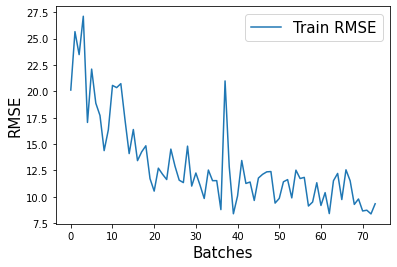

In [44]:
plt.figure()
plt.plot(train_rmse, label="Train RMSE")
plt.legend(fontsize=15)
plt.xlabel("Batches",fontsize=15)
plt.ylabel("RMSE",fontsize=15)
plt.show()
plt.close()

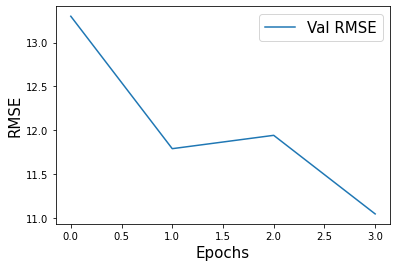

In [45]:
plt.figure()
plt.plot(val_rmse, label="Val RMSE")
plt.legend(fontsize=15)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("RMSE",fontsize=15)
plt.show()
plt.close()

Finally, after the model has been trained, we can easily evaluate it on the test set.

In [13]:
trainer.test(model=task, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 139.7346649169922, 'test_rmse': 10.717573165893555}
--------------------------------------------------------------------------------


[{'test_loss': 139.7346649169922, 'test_rmse': 10.717573165893555}]